# **EDA on Text Data**

## **Exploratory Data Analysis on SMS Spam Data**

This notebook explores a public dataset of SMS messages labeled as "spam" or "ham." We will:
- Load and inspect the data
- Engineer simple text-based features
- Clean and tokenize the text
- Visualize word frequencies, word clouds, distributions
- Perform sentiment analysis
- Use spaCy for part-of-speech tagging
- Conduct feature correlation analysis
- Remove low-frequency words


### 📚 **Recall: Key Concepts in Text Data EDA**

Before diving into the libraries and code, let’s revisit some essential points about **EDA** and how it applies to **text data**:

1. **What is Exploratory Data Analysis (EDA)?**  
   - EDA is the process of **examining datasets** to summarize their **main characteristics**, often using visual methods.  
   - In the context of **text data**, EDA helps us uncover patterns such as **frequent terms**, **text length distributions**, and **sentiment** tendencies.

2. **Why is EDA Important for Text Data?**  
   - Text data is **unstructured** compared to tabular data. Gaining insight into text requires methods such as **tokenization**, **frequency counting**, and **visualization** (e.g., **word clouds**).  
   - Through EDA, we can spot potential **biases**, **distribution skews**, or **common phrases** that might guide feature engineering and model selection.

3. **Common Steps in Text EDA**  
   - **Data Cleaning**: Removing punctuation, lowercasing, and dealing with special characters.  
   - **Tokenization**: Splitting text into individual words, tokens, or sentences.  
   - **Stopword Removal**: Filtering out high-frequency words (e.g., “the,” “and,” “is”) that usually don’t carry significant meaning.  
   - **Frequency Analysis**: Identifying the most common words, bigrams, or trigrams.  
   - **Visualization**: Using histograms, word clouds, or n-gram plots to get a quick overview of patterns.  
   - **Sentiment Analysis**: Gauging the **polarity** (positive/negative/neutral) to see how it differs across categories.

4. **Differences from Numeric EDA**  
   - Text data isn’t numeric by default, so direct descriptive statistics (like mean or variance) aren’t as straightforward.  
   - **Text-based features** (e.g., word counts, character counts, sentiment scores) must be engineered to make the data more tractable.  
   - Data exploration often focuses on linguistic structures (syntax, semantics) rather than purely statistical properties.

5. **Key Definitions**  
   - **Token**: A single instance of a sequence of characters in text (e.g., a word).  
   - **Lemmatization/Stemming**: Reducing words to their base or root form.  
   - **N-gram**: A contiguous sequence of *n* items (usually words) in text (e.g., bigrams or trigrams).  
   - **Sentiment**: A measure of how positive, negative, or neutral a piece of text may be, often derived through lexical approaches (like VADER) or machine learning models.

With these fundamentals refreshed, we are now ready to explore the specific tools and techniques that will help us analyze this SMS Spam dataset.


### 🔗 **Library Overview**

- **pandas** ([docs](https://pandas.pydata.org/docs/)): For data manipulation and analysis.
- **NumPy** ([docs](https://numpy.org/doc/)): Fundamental package for numerical computing in Python.
- **matplotlib** ([docs](https://matplotlib.org/stable/contents.html)): For creating static, animated, and interactive visualizations.
- **seaborn** ([docs](https://seaborn.pydata.org/)): Built on top of matplotlib for advanced statistical visualizations.
- **NLTK** ([docs](https://www.nltk.org/)): Natural Language Toolkit for common NLP tasks like tokenization and stopword removal.
- **spaCy** ([docs](https://spacy.io/)): Industrial-strength NLP library for tokenization, POS tagging, etc.
- **wordcloud** ([docs](https://amueller.github.io/word_cloud/)): For generating word cloud visualizations.
- **scikit-learn** ([docs](https://scikit-learn.org/stable/)): Provides utility functions like `CountVectorizer` for text processing.

## **Load Data**

In [1]:
# Importing necessary libraries
import pandas as pd

# Load the dataset
url = "https://raw.githubusercontent.com/mohitgupta-1O1/Kaggle-SMS-Spam-Collection-Dataset-/master/spam.csv"
data = pd.read_csv(url, encoding="ISO-8859-1")

# Data preview and cleaning
data = data.rename(columns={"v1": "label", "v2": "message"})
data = data[["label", "message"]]  # Keeping only relevant columns
data.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


**Explanation**  
- **pandas** is imported for data manipulation.  
- The CSV file is read from a URL; `encoding="ISO-8859-1"` handles any non-UTF-8 characters.  
- Columns are renamed to `label` and `message` for clarity.  
- Only the relevant columns (`label` and `message`) are kept.  
- `.head()` shows the first few rows of the dataframe.


## **Statistical Analysis**

## **Summary Statistics**

### **Creating Basic Text-Based Features**

In [2]:
# Calculate character count, word count, and average word length
data["char_count"] = data["message"].apply(len)
data["word_count"] = data["message"].apply(lambda x: len(x.split()))
data["avg_word_length"] = data["char_count"] / data["word_count"]

# Display the updated DataFrame
data.head()

,label,message,char_count,word_count,avg_word_length
0,ham,"Go until jurong point, crazy.. Available only ...",111,20,5.550000
1,ham,Ok lar... Joking wif u oni...,29,6,4.833333
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,28,5.535714
3,ham,U dun say so early hor... U c already then say...,49,11,4.454545
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,13,4.692308


**Explanation**  
- **char_count**: Total number of characters in the message, including spaces and punctuation.  
- **word_count**: Total number of words, split by whitespace.  
- **avg_word_length**: Computed as `char_count / word_count`.  
- These features provide basic quantitative insights into message length and complexity.


In [3]:
# Summary statistics
# Compute the mean of char_count, word_count, avg_word_length grouped by label
char_word_stats = data[["label", "char_count", "word_count", "avg_word_length"]].groupby("label").mean()
print(char_word_stats)

       char_count  word_count  avg_word_length
label                                         
ham     71.023627   14.200622         5.070165
spam   138.866131   23.851406         5.946532


**Explanation**  
- Groups the data by **label** (spam or ham) and calculates the **mean** for `char_count`, `word_count`, and `avg_word_length`.  
- Useful for comparing how these metrics differ between spam and ham messages.


### **Text Cleaning, Tokenization, and Frequency Analysis**

In [4]:
from nltk.tokenize import word_tokenize
from collections import Counter
import nltk
import string
from nltk.corpus import stopwords

# Download necessary NLTK packages
nltk.download('punkt_tab')
nltk.download('stopwords')

# Define a function to clean and tokenize text
def clean_tokenize_text(text):
    stop_words = set(stopwords.words('english'))
    text = text.lower()  # Convert to lowercase
    text = ''.join([char for char in text if char not in string.punctuation])  # Remove punctuation
    words = word_tokenize(text)  # Tokenize
    return [word for word in words if word not in stop_words]  # Remove stopwords

# Apply cleaning/tokenization and create a new column
data["cleaned_tokens"] = data["message"].apply(clean_tokenize_text)

# Separate spam and ham tokens
spam_tokens = [word for tokens in data[data['label'] == 'spam']["cleaned_tokens"] for word in tokens]
ham_tokens = [word for tokens in data[data['label'] == 'ham']["cleaned_tokens"] for word in tokens]

# Get word frequencies
spam_word_freq = Counter(spam_tokens)
ham_word_freq = Counter(ham_tokens)

# Top 15 most common words in spam and ham
spam_top_words = spam_word_freq.most_common(15)
ham_top_words = ham_word_freq.most_common(15)

# Create DataFrames for easy display/plotting
spam_df = pd.DataFrame(spam_top_words, columns=["Word", "Frequency"])
ham_df = pd.DataFrame(ham_top_words, columns=["Word", "Frequency"])


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


**Explanation**  
- **NLTK** is used for tokenizing and removing stopwords.  
- **clean_tokenize_text** function performs these steps:  
  1. Lowercases the text.  
  2. Removes punctuation.  
  3. Tokenizes words with `word_tokenize`.  
  4. Removes English stopwords.  
- The dataset is split into spam vs. ham tokens.  
- **Counter** calculates the frequency of each word in spam and ham.  
- The top 15 words for each label are extracted, then saved to `spam_df` and `ham_df`.


In [5]:
print("Top 15 Most Common Words in Spam Messages:")
spam_df.head(20)

Top 15 Most Common Words in Spam Messages:


,Word,Frequency
0,call,347
1,free,216
2,2,173
3,txt,150
4,u,147
5,ur,144
6,mobile,123
7,text,120
8,4,119
9,claim,113


**Explanation**  
- Prints the **top 15** spam words from `spam_df`.  
- Uses `.head(20)` to ensure we see at least 15 rows (with a little buffer).


In [6]:
print("\nTop 15 Most Common Words in Ham Messages:")
ham_df.head(20)


Top 15 Most Common Words in Ham Messages:


,Word,Frequency
0,u,972
1,im,449
2,2,305
3,get,303
4,ltgt,276
5,ok,272
6,dont,257
7,go,247
8,got,243
9,ur,240


**Explanation**  
- Prints the **top 15** ham words from `ham_df`.  
- Similarly uses `.head(20)` to display them (allowing enough rows for all 15).


###**Word Cloud for Spam and Ham Messages**

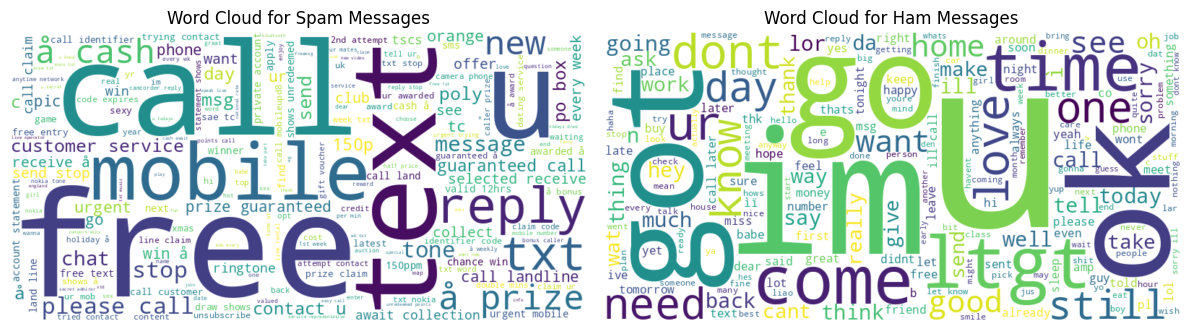

In [7]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Helper function for word cloud pre-processing
def preprocess_text(text):
    text = text.lower()
    text = ''.join([c for c in text if c not in string.punctuation])
    words = text.split()
    return [word for word in words if word not in stopwords.words('english')]

# Create joined text for spam and ham
spam_words = ' '.join(preprocess_text(' '.join(data[data['label'] == 'spam']["message"])))
ham_words = ' '.join(preprocess_text(' '.join(data[data['label'] == 'ham']["message"])))

# Generate word clouds
spam_cloud = WordCloud(width=800, height=400, background_color="white").generate(spam_words)
ham_cloud = WordCloud(width=800, height=400, background_color="white").generate(ham_words)

# Plot side by side
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(spam_cloud, interpolation="bilinear")
plt.title("Word Cloud for Spam Messages")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(ham_cloud, interpolation="bilinear")
plt.title("Word Cloud for Ham Messages")
plt.axis("off")

plt.tight_layout()
plt.show()


**Explanation**  
- Uses a helper function `preprocess_text` for lowercasing, removing punctuation, and filtering out stopwords.  
- Joins all spam and ham messages to form two big text strings.  
- Generates **WordCloud** objects for each label.  
- Displays them side by side for visual comparison.


### **Distribution of Word Count and Character Count**

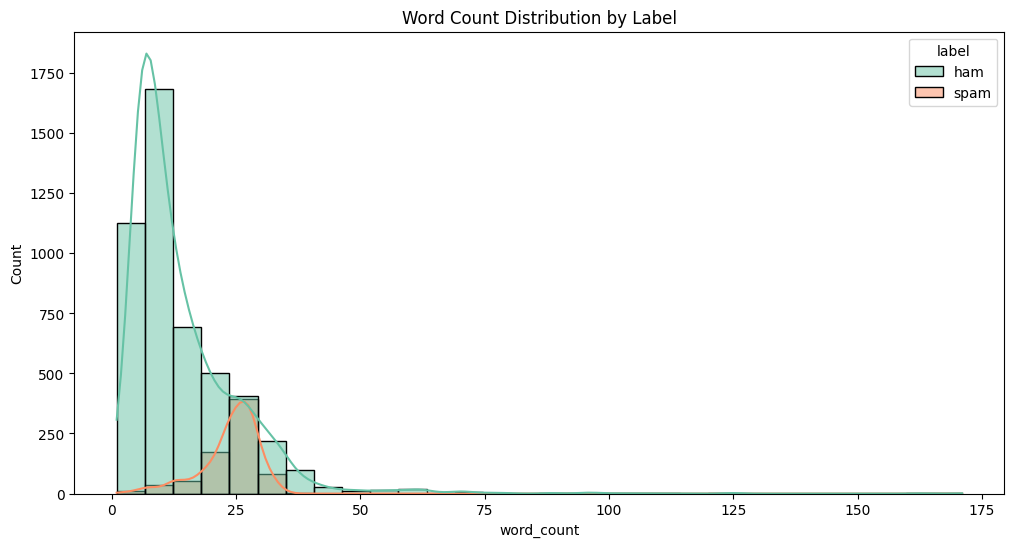

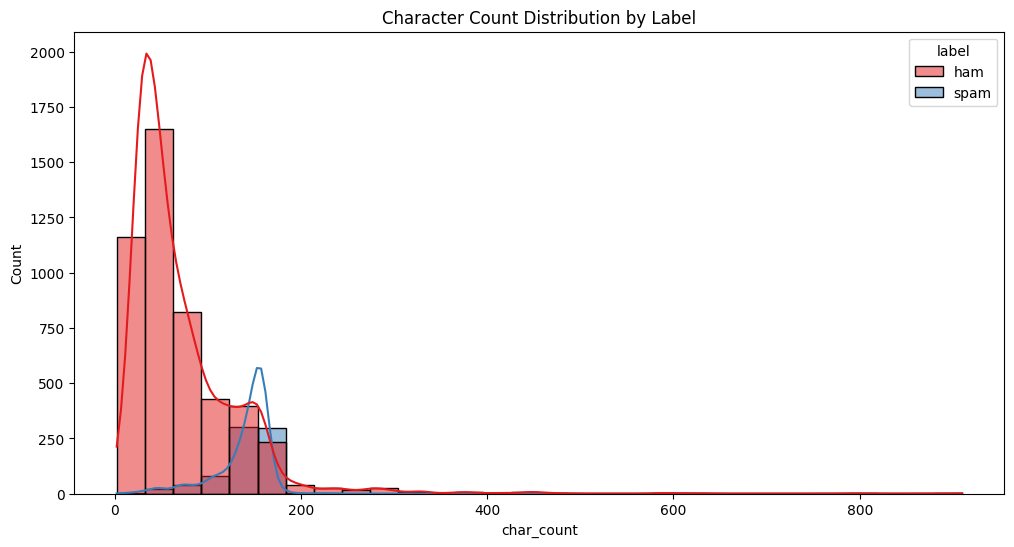

In [8]:
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.histplot(data, x="word_count", hue="label", bins=30, kde=True, palette="Set2")
plt.title("Word Count Distribution by Label")
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(data, x="char_count", hue="label", bins=30, kde=True, palette="Set1")
plt.title("Character Count Distribution by Label")
plt.show()


**Explanation**  
- Visualizes the **word_count** and **char_count** distributions, separated by spam vs. ham (with hue="label").  
- Uses `kde=True` to overlay a **kernel density estimate** curve.  
- Helps reveal differences in text length across the two categories.


### **N-Gram Extraction and Plotting**

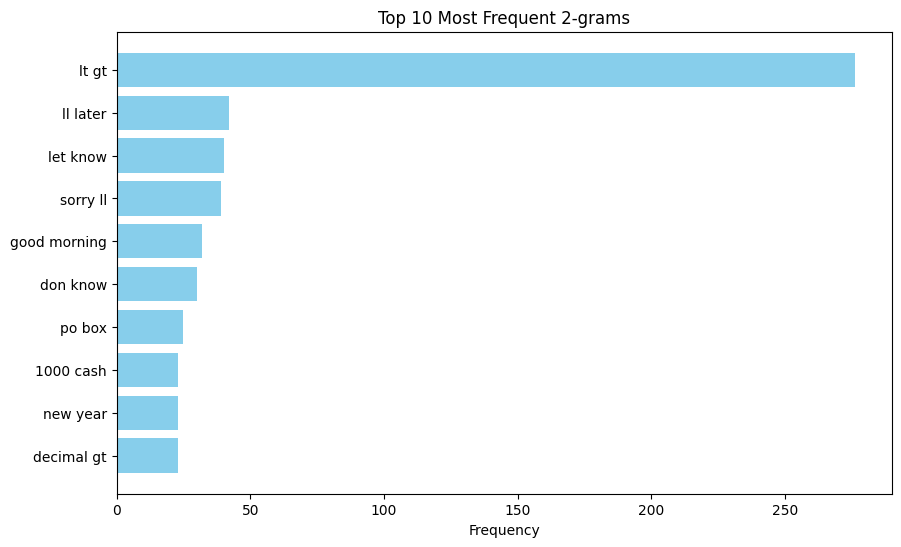

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

def plot_ngrams(data_series, n=2, top_n=10):
    """
    This function extracts n-grams from a Pandas Series of text data,
    identifies the top_n most frequent n-grams, and plots them.
    """
    vectorizer = CountVectorizer(ngram_range=(n, n), stop_words='english')
    ngram_matrix = vectorizer.fit_transform(data_series)
    ngram_freq = np.array(ngram_matrix.sum(axis=0)).flatten()
    ngram_terms = vectorizer.get_feature_names_out()

    # Get top N frequent n-grams
    top_indices = ngram_freq.argsort()[-top_n:][::-1]
    top_ngrams = [ngram_terms[i] for i in top_indices]
    top_frequencies = ngram_freq[top_indices]

    # Plot in a horizontal bar chart
    plt.figure(figsize=(10, 6))
    plt.barh(top_ngrams, top_frequencies, color='skyblue')
    plt.xlabel('Frequency')
    plt.title(f'Top {top_n} Most Frequent {n}-grams')
    plt.gca().invert_yaxis()
    plt.show()

# Example usage: plotting top 10 most frequent bigrams
plot_ngrams(data['message'], n=2, top_n=10)


**Explanation**  
- Uses **scikit-learn**’s `CountVectorizer` to transform the text data into an **n-gram frequency matrix**.  
- Extracts the top `top_n` most frequent n-grams (bigrams by default).  
- Displays them in a horizontal bar chart for quick comparison.


### **Sentiment Analysis (VADER)**

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


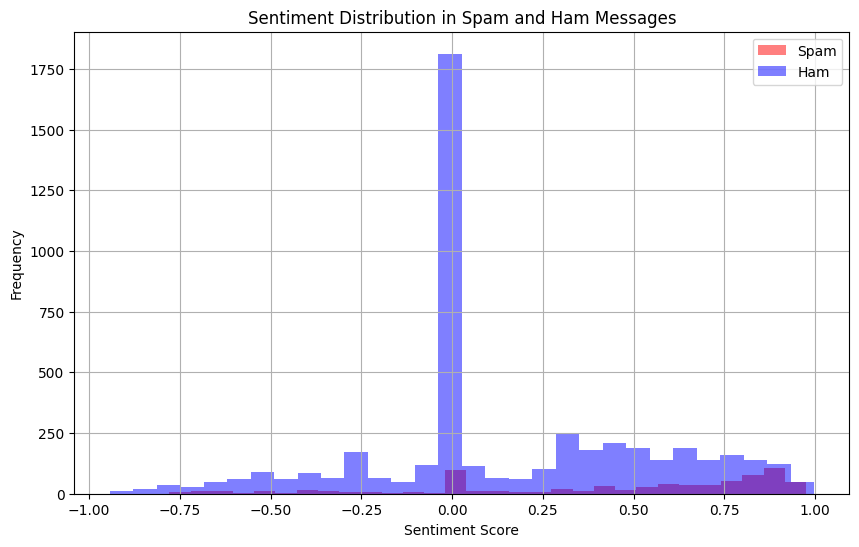

In [10]:
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

nltk.download('vader_lexicon')

# Initialize sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Compute sentiment scores for each message
data['sentiment'] = data['message'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Plot histograms of spam vs. ham sentiment
plt.figure(figsize=(10, 6))
data[data['label'] == 'spam']['sentiment'].hist(alpha=0.5, bins=30, label='Spam', color='red')
data[data['label'] == 'ham']['sentiment'].hist(alpha=0.5, bins=30, label='Ham', color='blue')
plt.legend()
plt.title('Sentiment Distribution in Spam and Ham Messages')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()


**Explanation**  
- Downloads and uses **VADER** lexicon from NLTK.  
- Applies `SentimentIntensityAnalyzer` on each message, extracting the overall **compound** score.  
- Plots overlapping histograms to compare sentiment distributions for spam vs. ham messages.


### **Part-of-Speech (POS) Tagging with spaCy**

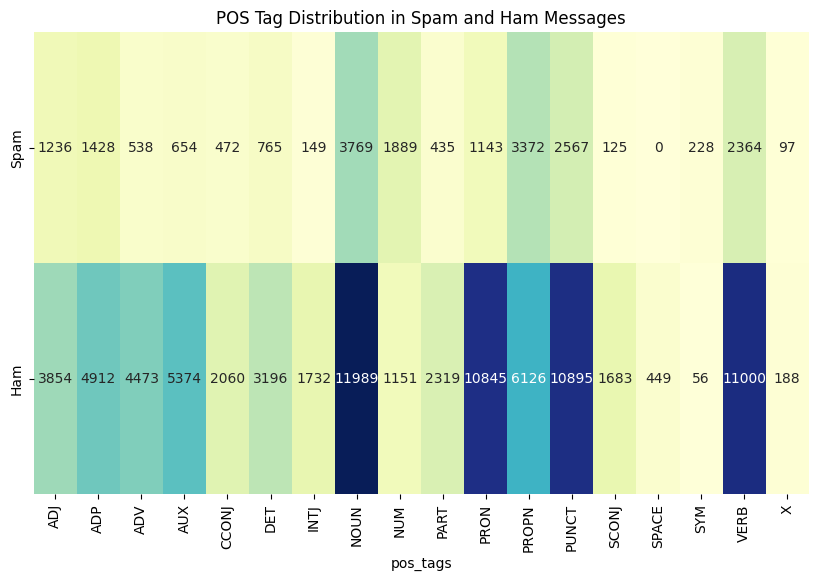

In [11]:
import spacy
import seaborn as sns

# Load spaCy model (ensure 'en_core_web_sm' is installed: python -m spacy download en_core_web_sm)
nlp = spacy.load("en_core_web_sm")

# Apply POS tagging on each message
data['pos_tags'] = data['message'].apply(lambda x: [token.pos_ for token in nlp(x)])

# Count POS tags for spam vs ham
pos_counts_spam = data[data['label'] == 'spam']['pos_tags'].explode().value_counts()
pos_counts_ham = data[data['label'] == 'ham']['pos_tags'].explode().value_counts()

# Create a DataFrame for the comparison
pos_df = pd.DataFrame({'Spam': pos_counts_spam, 'Ham': pos_counts_ham}).fillna(0)

# Visualize POS distribution using a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pos_df.T, annot=True, cmap='YlGnBu', fmt='.0f', cbar=False)
plt.title('POS Tag Distribution in Spam and Ham Messages')
plt.show()


**Explanation**  
- Loads **spaCy**'s small English model `en_core_web_sm` for POS tagging.  
- Applies spaCy’s pipeline to each message, storing a list of POS tags in `pos_tags`.  
- Counts each POS tag’s frequency within spam and ham.  
- Displays the results in a heatmap, allowing quick comparison of grammatical patterns.


In [12]:
# Exploring POS Tags on a Single Example
for token in nlp(data['message'][0]):
    print(f"Token: {token.text}, POS: {token.pos_}")

Token: Go, POS: VERB
Token: until, POS: ADP
Token: jurong, POS: PROPN
Token: point, POS: NOUN
Token: ,, POS: PUNCT
Token: crazy, POS: ADJ
Token: .., POS: PUNCT
Token: Available, POS: ADJ
Token: only, POS: ADV
Token: in, POS: ADP
Token: bugis, POS: ADJ
Token: n, POS: CCONJ
Token: great, POS: ADJ
Token: world, POS: NOUN
Token: la, POS: PROPN
Token: e, POS: PROPN
Token: buffet, POS: NOUN
Token: ..., POS: PUNCT
Token: Cine, POS: PROPN
Token: there, POS: ADV
Token: got, POS: VERB
Token: amore, POS: PROPN
Token: wat, POS: NOUN
Token: ..., POS: PUNCT


**Explanation**  
- Demonstrates how spaCy processes a single message at the **token** level.  
- Prints each token and its corresponding **POS** tag.  
- Useful for a quick inspection of spaCy’s tagging behavior on an example.


### **Additional Feature Engineering and Correlation**

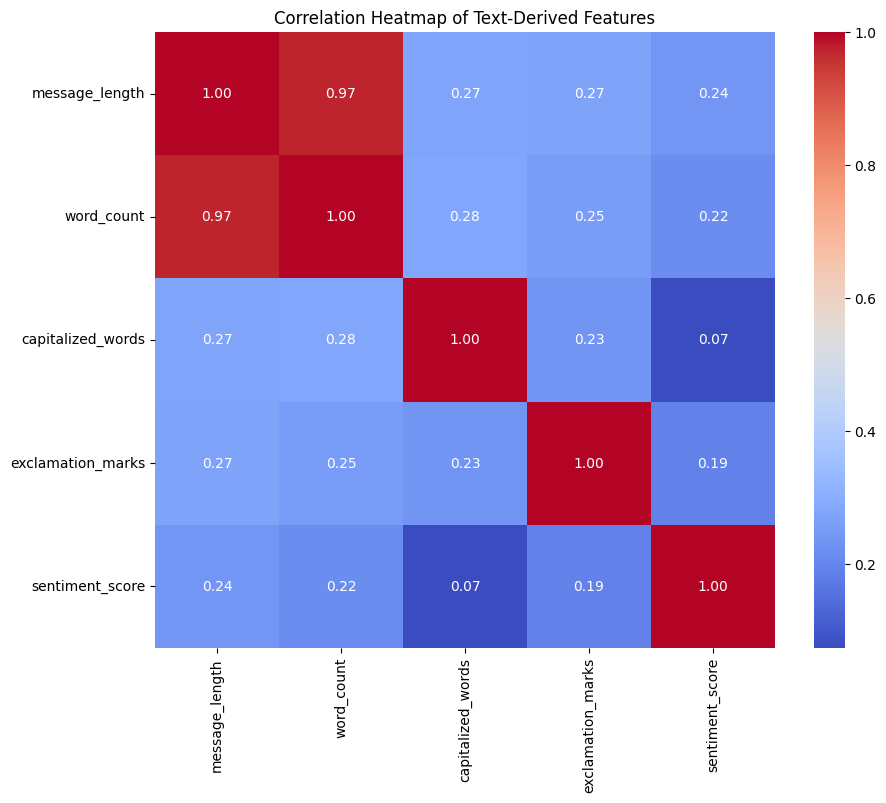

In [13]:

import seaborn as sns
import matplotlib.pyplot as plt

# Create additional text-based features
data['message_length'] = data['message'].apply(len)
data['word_count'] = data['message'].apply(lambda x: len(x.split()))
data['capitalized_words'] = data['message'].apply(lambda x: sum(1 for word in x.split() if word.isupper()))
data['exclamation_marks'] = data['message'].apply(lambda x: x.count('!'))
data['sentiment_score'] = data['message'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Compute correlation among these new features
correlation_matrix = data[['message_length', 'word_count', 'capitalized_words',
                           'exclamation_marks', 'sentiment_score']].corr()

# Plot a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title('Correlation Heatmap of Text-Derived Features')
plt.show()


**Explanation**  
- Creates new features:
  - `capitalized_words`: Counts uppercase words.  
  - `exclamation_marks`: Counts '!' punctuation.  
  - `sentiment_score`: Reuses the VADER compound score.  
- Computes and plots a **correlation matrix** to see relationships among these features.  
- A **heatmap** visualization reveals which text-derived features might be correlated.


### **Removing Low-Frequency Words**

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

# Transform messages into bag-of-words representation
vectorizer = CountVectorizer(lowercase=True, stop_words='english')
word_counts = vectorizer.fit_transform(data['message'])

# Convert the word counts to a DataFrame
word_counts_df = pd.DataFrame(word_counts.toarray(), columns=vectorizer.get_feature_names_out())

# Sum the frequencies of each word across all documents
word_frequencies = word_counts_df.sum(axis=0)

# Define a threshold for low-frequency words
threshold = 5
low_frequency_words = word_frequencies[word_frequencies < threshold].index

# Remove columns corresponding to low-frequency words
filtered_data = word_counts_df.drop(columns=low_frequency_words)

print(f"Original number of words: {word_counts_df.shape[1]}")
print(f"Number of low-frequency words removed: {len(low_frequency_words)}")
print(f"Number of words after filtering: {filtered_data.shape[1]}")


Original number of words: 8404
Number of low-frequency words removed: 6761
Number of words after filtering: 1643


**Explanation**  
- Converts text messages into a **bag-of-words** matrix with `CountVectorizer`.  
- Sums the total occurrences of each word across all messages.  
- Defines a threshold (e.g., words appearing fewer than 5 times) as “low frequency.”  
- Removes these low-frequency words from the DataFrame.  
- Shows how many words were removed vs. how many remain.

# **Optional: Further Exploration**

Here are some suggestions and small challenges for those who want to delve deeper into text analysis and EDA:

1. **Custom Word Clouds**  
   - Experiment with different `WordCloud` parameters (e.g., color maps, shapes, max words).  
   - Try generating word clouds for **bigrams** or **trigrams** by joining tokens with `_`.  
     - *Hint:* Preprocess your text into bigrams, then create a single string of those bigrams for the word cloud.

2. **Comparing N-Grams Between Spam and Ham**  
   - Use the `plot_ngrams` function (or a custom variation) to visualize **top 10 trigrams** for spam vs. ham.  
   - Are there phrases that appear primarily in spam messages? In ham messages?

3. **Custom Sentiment or Polarity Measures**  
   - We used VADER for sentiment, but you can explore other approaches (e.g., [TextBlob](https://textblob.readthedocs.io/en/dev/)).  
   - Compare the sentiment scores from **two different sentiment analyzers**. Are they consistent?

4. **Explore Stopwords**  
   - Check which words are in the default English stopword list.  
   - Try creating a **custom stopword list** for SMS text (e.g., removing words like “u,” “ur,” etc.).  
   - Evaluate how it changes your word frequencies and visualizations.

5. **Play with POS Tagging**  
   - Filter tokens by POS tags (e.g., keep only **nouns**).  
   - Observe how the frequency of nouns vs. verbs vs. adjectives varies in spam vs. ham.

6. **Try a Mini Classification Approach**  
   - Go beyond EDA: Convert the text into numerical features (e.g., bag-of-words or TF-IDF) and see if you can **predict** whether a message is spam or ham with a simple classifier (e.g., Logistic Regression).  
   - *Note:* This step requires splitting into training/test sets, which is beyond the scope of EDA but provides a natural next step.

---

### **Sample Code Snippet**

Below is a small template you can adapt for a quick DIY exercise. Feel free to extend or modify it.

```python
# EXERCISE: Tokenize messages into bigrams and visualize the most common bigrams in spam vs ham.

def plot_top_bigrams_by_label(df, label_col='label', text_col='message', top_n=10):
    """
    Plots the top N bigrams for each unique label in the label_col.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.feature_extraction.text import CountVectorizer
    
    unique_labels = df[label_col].unique()
    
    for label_val in unique_labels:
        subset = df[df[label_col] == label_val]
        
        vectorizer = CountVectorizer(ngram_range=(2,2), stop_words='english')
        X = vectorizer.fit_transform(subset[text_col])
        
        # Compute frequencies
        freqs = np.sum(X.toarray(), axis=0)
        
        # Get indices of top N bigrams
        top_indices = freqs.argsort()[-top_n:][::-1]
        top_ngrams = [vectorizer.get_feature_names_out()[i] for i in top_indices]
        top_freqs = freqs[top_indices]
        
        # Plot
        plt.figure(figsize=(10,6))
        plt.barh(top_ngrams, top_freqs, color='cornflowerblue')
        plt.gca().invert_yaxis()
        plt.title(f"Top {top_n} Bigrams in {label_val} Messages")
        plt.xlabel("Frequency")
        plt.show()

# Try the function
plot_top_bigrams_by_label(data, label_col='label', text_col='message', top_n=10)


# 🔗 **Additional Resources for EDA on Text Data**

## Blogs
1. [**Exploratory Data Analysis For Text Data | EDA Using Python** by Analytics Vidhya](https://www.analyticsvidhya.com/blog/2020/04/beginners-guide-exploratory-data-analysis-text-data/)

2. [**Exploratory Data Analysis for Natural Language Processing: A Complete Guide to Python Tools** by Neptune.ai](https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools)

3. [**Exploratory Data Analysis (EDA) on Text Data with Python** by Towards AI](https://towardsai.net/p/data-science/exploratory-data-analysis-eda-on-text-data-with-python)

## YouTube Videos
1. [**Complete Exploratory Data Analysis (EDA) on Text Data in Python**](https://www.youtube.com/watch?v=HVBk2Ge_Q98)

2. [**PYTHON Exploratory Data Analysis on Text Data | EDA [End to End Project]**](https://www.youtube.com/watch?v=qXwsMftFFtk)

3. [**How to do Exploratory Data Analysis and Visualization of Text Dataset using Python**](https://www.youtube.com/watch?v=zCznZoKnfBA)


# 📚 **Some Kaggle Notebooks for EDA on Text Data**

1. [**Complete Guide to EDA on Text Data** by Harsh Singh](https://www.kaggle.com/code/harshsingh2209/complete-guide-to-eda-on-text-data)

2. [**Complete EDA and Visualization of Text Data** by Bhavesh Kumar](https://www.kaggle.com/code/bhaveshkumar2806/complete-eda-and-visualization-of-text-data)

3. [**EDA for Text Data - NLP** by Krishna Rai](https://www.kaggle.com/code/krrai77/eda-for-text-data-nlp)
